In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import glob
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline
import keras
from keras.models import Sequential
from sklearn.utils import class_weight
from keras.utils.np_utils import to_categorical 

import os, shutil
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
import os, os.path
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D
from keras import backend as K
from keras import optimizers

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [0]:
# Define path to the data directory
data_dir = Path('/content/drive/My Drive/dsc-mod-4-project-v2-1-online-ds-ft-120919/chest_xray/chest_xray')

# Path to train directory (Fancy pathlib...no more os.path!!)
train_dir = data_dir / 'train'

# Path to validation directory
val_dir = data_dir / 'val'

# Path to test directory
test_dir = data_dir / 'test'

In [0]:
train_normal_cases_dir = train_dir / 'NORMAL'
train_pneumonia_cases_dir = train_dir / 'PNEUMONIA'

train_normal_cases = train_normal_cases_dir.glob('*.jpeg')
train_pneumonia_cases = train_pneumonia_cases_dir.glob('*.jpeg')


# Test data too
test_normal_cases_dir = test_dir / 'NORMAL'
test_pneumonia_cases_dir = test_dir / 'PNEUMONIA'

test_normal_cases = test_normal_cases_dir.glob('*.jpeg')
test_pneumonia_cases = test_pneumonia_cases_dir.glob('*.jpeg')



In [5]:
# An empty list. We will insert the data into this list in (img_path, label) format
train_data = []

# Go through all the normal cases. The label for these cases will be 0
for img in train_normal_cases:
    train_data.append((img,0))

# Go through all the pneumonia cases. The label for these cases will be 1
for img in train_pneumonia_cases:
    train_data.append((img, 1))

# Get a pandas dataframe from the data we have in our list 
train_df = pd.DataFrame(train_data, columns=['image', 'label'],index=None)

# Shuffle the data 
train_df = train_df.sample(frac=1.).reset_index(drop=True)

# Create column for read ability
train_df["label_name"] = ["pneumonia" if label  == 1 else "normal" for label in train_df["label"]]


# How the dataframe looks like?
train_df.head()



,image,label,label_name
0,/content/drive/My Drive/dsc-mod-4-project-v2-1...,0,normal
1,/content/drive/My Drive/dsc-mod-4-project-v2-1...,0,normal
2,/content/drive/My Drive/dsc-mod-4-project-v2-1...,0,normal
3,/content/drive/My Drive/dsc-mod-4-project-v2-1...,1,pneumonia
4,/content/drive/My Drive/dsc-mod-4-project-v2-1...,0,normal


In [6]:
# An empty list. We will insert the data into this list in (img_path, label) format
test_data = []

# Go through all the normal cases. The label for these cases will be 0
for img in test_normal_cases:
    test_data.append((img,0))

# Go through all the pneumonia cases. The label for these cases will be 1
for img in test_pneumonia_cases:
    test_data.append((img, 1))

# Get a pandas dataframe from the data we have in our list 
test_df = pd.DataFrame(test_data, columns=['image', 'label'],index=None)

# Shuffle the data 
test_df = test_df.sample(frac=1.).reset_index(drop=True)

# Create column for read ability
test_df["label_name"] = ["pneumonia" if label  == 1 else "normal" for label in test_df["label"]]


# How the dataframe looks like?
test_df.head()



,image,label,label_name
0,/content/drive/My Drive/dsc-mod-4-project-v2-1...,0,normal
1,/content/drive/My Drive/dsc-mod-4-project-v2-1...,0,normal
2,/content/drive/My Drive/dsc-mod-4-project-v2-1...,1,pneumonia
3,/content/drive/My Drive/dsc-mod-4-project-v2-1...,1,pneumonia
4,/content/drive/My Drive/dsc-mod-4-project-v2-1...,1,pneumonia


In [7]:
# Checking the len of normal and pnemonia images we have

print("Training Normal:", len(train_df.loc[train_df['label'] == 0]))
print("Training Pneumonia:", len(train_df.loc[train_df['label'] == 1]), '\n')


print("Test Normal:", len(test_df.loc[test_df['label'] == 0]))
print("Test Pneumonia:", len(test_df.loc[test_df['label'] == 1]), '\n')


Training Normal: 3639
Training Pneumonia: 3875 

Test Normal: 234
Test Pneumonia: 390 



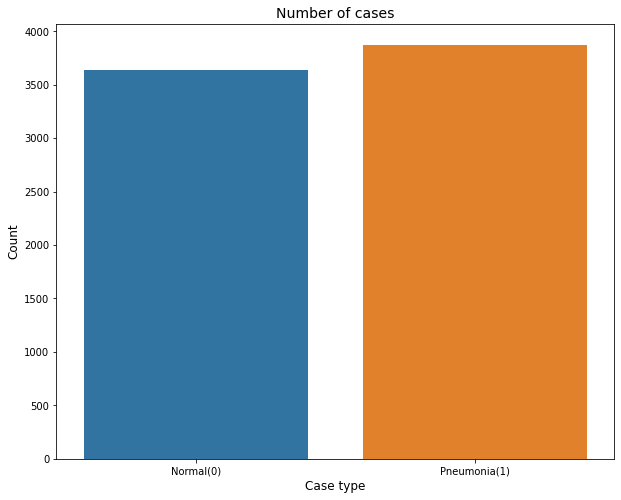

In [8]:
cases_count = train_df['label'].value_counts()

plt.figure(figsize=(10,8))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'Pneumonia(1)'])
plt.show()

In [0]:

test_datagen = ImageDataGenerator(rescale=1./255)
# val_datagen = ImageDataGenerator(rescale=1./255)

In [10]:
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   shear_range=0.2, 
                                   horizontal_flip=True, 
                                   fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(240, 240),
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')



test_generator = test_datagen.flow_from_directory(test_dir,
                                                        target_size=(240, 240),
                                                        class_mode='binary')



Found 7514 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [0]:
model_2 = Sequential()
model_2.add(Conv2D(32, (3, 3), activation='relu', input_shape=(240, 240, 3)))
model_2.add(MaxPooling2D((2, 2)))
model_2.add(Conv2D(32, (3, 3), activation='relu'))
model_2.add(MaxPooling2D((2, 2)))
model_2.add(Conv2D(64, (3, 3), activation='relu'))
model_2.add(MaxPooling2D((2, 2)))
model_2.add(Conv2D(128, (3, 3), activation='relu'))
model_2.add(MaxPooling2D((2, 2)))
model_2.add(Conv2D(214, (3, 3), activation='relu'))
model_2.add(MaxPooling2D((2, 2)))
model_2.add(Flatten())
# model_2.add(Dense(128, activation='relu'))
model_2.add(Dense(512, activation='relu'))
model_2.add(Dense(1, activation='sigmoid'))


In [12]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 238, 238, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 119, 119, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 117, 117, 32)      9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 58, 58, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 26, 26, 128)      

In [0]:
# opt = optimizers.Adam(lr=0.0001)
opt = optimizers.Adam(lr=0.1)
es = EarlyStopping(patience=5)
chkpt = ModelCheckpoint(filepath='best_model_todate', save_best_only=True, save_weights_only=True)

model_2.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['acc'])

In [0]:
# class_weights = {0:60, 1:3}

In [15]:
history_ = model_2.fit_generator(train_generator,
                              steps_per_epoch=100, 
                              epochs=10, )

                              # validation_data=test_generator, 
                              # validation_steps=50)
                              # class_weight=class_weights)
# CHAPSTICK AND CRAZY GLUe

Epoch 1/10
100/100 [==============================] - 1812s 18s/step - loss: 145308.8849 - acc: 0.4944
Epoch 2/10
100/100 [==============================] - 1779s 18s/step - loss: 1.3640 - acc: 0.5059
Epoch 3/10
100/100 [==============================] - 838s 8s/step - loss: 0.8328 - acc: 0.4962
Epoch 4/10
100/100 [==============================] - 300s 3s/step - loss: 0.8130 - acc: 0.5172
Epoch 5/10
100/100 [==============================] - 298s 3s/step - loss: 0.7235 - acc: 0.4878
Epoch 6/10
100/100 [==============================] - 298s 3s/step - loss: 0.7102 - acc: 0.4956
Epoch 7/10
100/100 [==============================] - 296s 3s/step - loss: 0.7057 - acc: 0.5034
Epoch 8/10
100/100 [==============================] - 305s 3s/step - loss: 0.7134 - acc: 0.4925
Epoch 9/10
100/100 [==============================] - 306s 3s/step - loss: 0.6971 - acc: 0.5175
Epoch 10/10
100/100 [==============================] - 308s 3s/step - loss: 0.7039 - acc: 0.4847


CHECK AND MAKE EPOCHS AND STEPS SIZ


In [16]:
acc = history_.history['acc']
val_acc = history_.history['val_acc']
loss = history_.history['loss']
val_loss = history_.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

KeyError: ignored

In [0]:
test_loss, test_acc = model_2.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

In [0]:
preds = np.round(model_2.predict_generator(test_generator))
preds.flatten()

In [0]:
accuracy_score(test_df['label'], preds)

In [0]:

print(classification_report(test_df['label'], preds))

In [0]:
cm = confusion_matrix(test_df['label'], preds)
sns.heatmap(cm, xticklabels=("actual0", "actual1"), cmap="Blues", annot=True, fmt='.3g')